In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap


In [17]:
def combine_names(x):
    if 'Lawrenceville' in x:
        x = 'Lawrenceville'
    elif 'Oakland' in x:
        x = 'Oakland'
    elif 'Squirrel Hill' in x:
        x = 'Squirrel Hill'
    return x

district_names = ["Central Business District","Strip District","Shadyside","Squirrel Hill",
                  "Oakland","South Side Flats","Bloomfield","Highland Park","East Liberty",
                  "North Shore","Lawrenceville","Greenfield","Hazelwood"]
df = pd.read_csv("https://data.wprdc.org/datastore/dump/8d76ac6b-5ae8-4428-82a4-043130d17b02")
df = df[['_id','incident_type','type_description','neighborhood']]
df = df.dropna()
df['neighborhood'] = df['neighborhood'].apply(combine_names)
df = df[df['neighborhood'].isin(district_names)]

In [18]:
fires = df.assign(count=1)
fires = fires.groupby('neighborhood',as_index=False).sum()
fires = fires.sort_values('count',ascending=False,ignore_index=True)
fires[['neighborhood','count']]

,neighborhood,count
0,Squirrel Hill,406
1,Oakland,396
2,Central Business District,292
3,South Side Flats,290
4,Hazelwood,257
5,East Liberty,219
6,Lawrenceville,198
7,Shadyside,193
8,Bloomfield,183
9,Greenfield,124


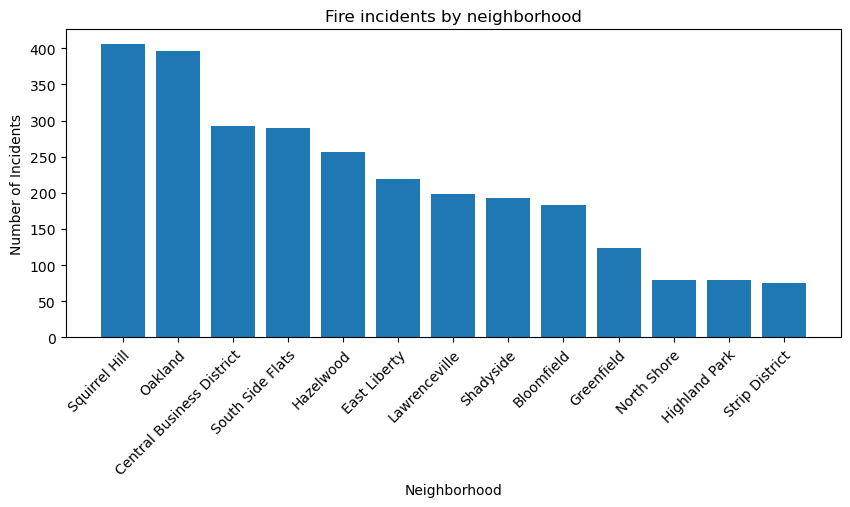

In [19]:
hoods = fires['neighborhood']
counts = fires['count']

fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(hoods,counts)
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Number of Incidents')
ax.set_title('Fire incidents by neighborhood')
plt.show()

In [20]:
lats = {
    "Central Business District":40.4418,
    "Strip District":40.4534,
    "Shadyside":40.4548,
    "Squirrel Hill":40.4456,
    "Oakland":40.4321,
    "South Side Flats":40.4284,
    "Bloomfield":40.4622,
    "Highland Park":40.4799,
    "East Liberty":40.4643,
    "North Shore":40.4467,
    "Lawrenceville":40.4698,
    "Greenfield":40.4242,
    "Hazelwood":40.409}
lons = {
    "Central Business District":-80.0004,
    "Strip District":-79.9807,
    "Shadyside":-79.9326,
    "Squirrel Hill":-79.9277,
    "Oakland":-79.9585,
    "South Side Flats":-79.9736,
    "Bloomfield":-79.9445,
    "Highland Park":-79.9165,
    "East Liberty":-79.9263,
    "North Shore":-80.0130,
    "Lawrenceville":-79.9609,
    "Greenfield":-79.9363,
    "Hazelwood":-79.941}

fires['lat'] = fires['neighborhood'].map(lats)
fires['lon'] = fires['neighborhood'].map(lons)
map_center = [40.439,-79.95]# [40.4406,-79.9959]
my_map = folium.Map(location=map_center, zoom_start=13)
HeatMap(fires[['lat', 'lon', 'count']].values, radius=40).add_to(my_map)
my_map

In [90]:
fire_types = {'high':[110,111,112,120,121,122,123,141,142,161,162,163],
              'moderate':[113,130,131,132,133,134,135,136,138,140,143,164],
              'low':[114,115,116,117,118,150,151,152,153,154,155]}
levels = list(fire_types.keys())
hazards = df.copy()
hazards.loc[hazards['incident_type'].isin(fire_types['low']),'hazard_level'] = 'low'
hazards.loc[hazards['incident_type'].isin(fire_types['moderate']),'hazard_level'] = 'moderate'
hazards.loc[hazards['incident_type'].isin(fire_types['high']),'hazard_level'] = 'high'
hazards.replace('nan',np.nan,inplace=True)
hazards = hazards.dropna()
hazards = hazards.assign(count=1)

countdf = pd.DataFrame(columns=['neighborhood','low','moderate','high','total'])
countdf['neighborhood'] = district_names
for level in levels:
    typedata = hazards[hazards['hazard_level']==level]
    typedata = typedata.groupby('neighborhood',as_index=False).sum()
    typemap = dict(typedata[['neighborhood','count']].values)
    countdf[level] = countdf['neighborhood'].map(typemap)
    
countdf['total'] = countdf['low']+countdf['moderate']+countdf['high']
countdf['percent_low'] = countdf['low']/countdf['total']*100
countdf['percent_moderate'] = countdf['moderate']/countdf['total']*100
countdf['percent_high'] = countdf['high']/countdf['total']*100
countdf.sort_values('percent_low',ascending=False,inplace=True,ignore_index=True)
countdf

,neighborhood,low,moderate,high,total,percent_low,percent_moderate,percent_high
0,North Shore,40,20,19,79,50.632911,25.316456,24.050633
1,South Side Flats,103,109,53,265,38.867925,41.132075,20.000000
2,Central Business District,110,112,62,284,38.732394,39.436620,21.830986
3,Hazelwood,89,93,68,250,35.600000,37.200000,27.200000
4,Strip District,21,28,21,70,30.000000,40.000000,30.000000
5,Greenfield,33,44,38,115,28.695652,38.260870,33.043478
6,Oakland,106,178,97,381,27.821522,46.719160,25.459318
7,Highland Park,20,37,16,73,27.397260,50.684932,21.917808
8,Lawrenceville,49,70,65,184,26.630435,38.043478,35.326087
9,East Liberty,54,96,65,215,25.116279,44.651163,30.232558


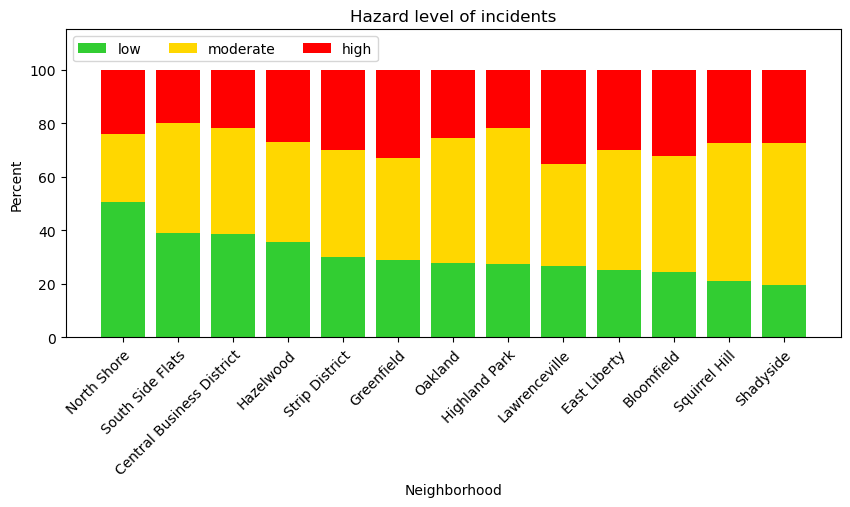

In [91]:
fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(countdf['neighborhood'],countdf['percent_low'],color='limegreen')
ax.bar(countdf['neighborhood'],countdf['percent_moderate'],bottom=countdf['percent_low'],color='gold')
ax.bar(countdf['neighborhood'],countdf['percent_high'],bottom=countdf['percent_low']+countdf['percent_moderate'],color='red')
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_ylim(0, 115)
ax.legend(['low','moderate','high'], loc="upper left",ncols=3)
ax.set_title('Hazard level of incidents')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Percent')
plt.show()

In [137]:
fires['fire_pts'] = round((max(fires['count'])-fires['count'])/10)
haz = countdf[['neighborhood','percent_low','percent_moderate','percent_high']].copy()
haz[['percent_low','percent_moderate','percent_high']] = countdf[['percent_low','percent_moderate','percent_high']].div(100)
haz['low_pts'] = haz['percent_low']*90
haz['moderate_pts'] = haz['percent_moderate']*10
haz['high_pts'] = haz['percent_high']*-70
haz['total'] = round(haz['low_pts']+haz['moderate_pts']+haz['high_pts'])

pts = pd.merge(fires[['neighborhood','fire_pts']],haz[['neighborhood','low_pts','moderate_pts','high_pts']],on='neighborhood')
pts['total'] = pts.drop('neighborhood',axis=1).sum(axis=1)
pts = pts.sort_values('total',ascending=False,ignore_index=True)
pts

,neighborhood,fire_pts,low_pts,moderate_pts,high_pts,total
0,North Shore,33.0,45.569620,2.531646,-16.835443,64.265823
1,Highland Park,33.0,24.657534,5.068493,-15.342466,47.383562
2,Strip District,33.0,27.000000,4.000000,-21.000000,43.000000
3,South Side Flats,12.0,34.981132,4.113208,-14.000000,37.094340
4,Greenfield,28.0,25.826087,3.826087,-23.130435,34.521739
5,Central Business District,11.0,34.859155,3.943662,-15.281690,34.521127
6,Hazelwood,15.0,32.040000,3.720000,-19.040000,31.720000
7,Bloomfield,22.0,22.095808,4.311377,-22.634731,25.772455
8,East Liberty,19.0,22.604651,4.465116,-21.162791,24.906977
9,Shadyside,21.0,17.704918,5.300546,-19.125683,24.879781


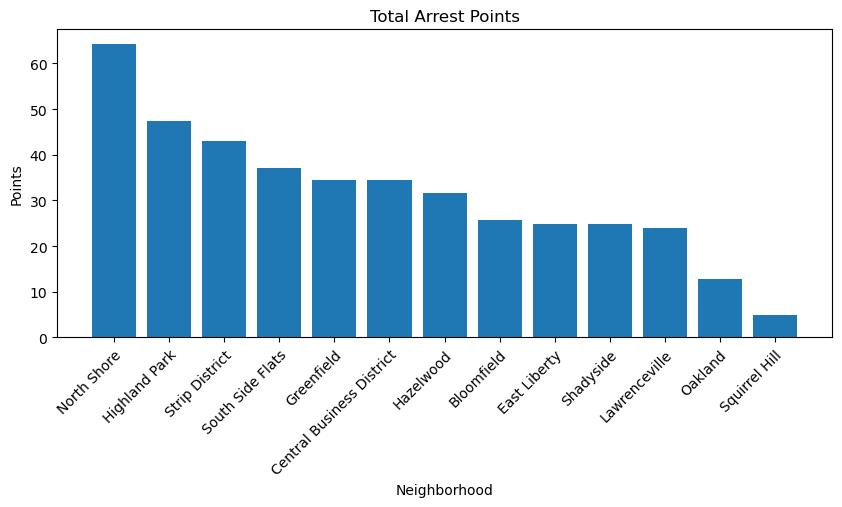

In [139]:
hoods = pts['neighborhood']
counts = pts['total']

fig,ax = plt.subplots(figsize=(10, 4))
ax.bar(hoods,counts)
ax.set_xticks(hoods,labels=hoods,rotation=45,rotation_mode='anchor',ha='right')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Points')
ax.set_title('Total Arrest Points')
plt.show()